In [8]:
import pandas as pd
import lime
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt
import logging
import sys
import os
import numpy as np

from joblib import load  # To load the saved model


In [9]:

sys.path.append(os.path.abspath("../"))


from scripts.model import prepare_data, split_data

from src import data_loader as dl
from scripts.logger import logger 
from scripts.Model_Explainability import load_model,lime_explainability,global_feature_importance,pdp_ice_plots,plot_roc_auc


In [10]:

credit = dl.load_data("creditcard.csv")
fraud_df = dl.load_data("processed/processed_fraud_data.csv")
# Remove duplicates
credit = credit.drop_duplicates()
credit["Class"] = credit["Class"].astype(bool)



2025-07-20 16:28:11,905 - INFO - Attempting to load data from: c:\Users\HP\Desktop\10 acd\week 8 -9\data\creditcard.csv


2025-07-20 16:28:11,905 - INFO - Attempting to load data from: c:\Users\HP\Desktop\10 acd\week 8 -9\data\creditcard.csv


2025-07-20 16:28:13,855 - INFO - Data successfully loaded from: c:\Users\HP\Desktop\10 acd\week 8 -9\data\creditcard.csv


2025-07-20 16:28:13,855 - INFO - Data successfully loaded from: c:\Users\HP\Desktop\10 acd\week 8 -9\data\creditcard.csv


2025-07-20 16:28:13,855 - INFO - Attempting to load data from: c:\Users\HP\Desktop\10 acd\week 8 -9\data\processed/processed_fraud_data.csv


2025-07-20 16:28:13,855 - INFO - Attempting to load data from: c:\Users\HP\Desktop\10 acd\week 8 -9\data\processed/processed_fraud_data.csv


2025-07-20 16:28:14,505 - INFO - Data successfully loaded from: c:\Users\HP\Desktop\10 acd\week 8 -9\data\processed/processed_fraud_data.csv


2025-07-20 16:28:14,505 - INFO - Data successfully loaded from: c:\Users\HP\Desktop\10 acd\week 8 -9\data\processed/processed_fraud_data.csv


In [11]:


# to match the number of instances in the minority class.

# Randomly shuffle the entire dataset to ensure randomness
df = credit.sample(frac=1, random_state=42).reset_index(drop=True)

# Isolate the minority class (fraud) with 473 instances
minority_class = df.loc[df['Class'] == 1]

# Select a random subset of the majority class (non-fraud) with the same number of instances as the minority class
majority_class_subset = df.loc[df['Class'] == 0].sample(n=473, random_state=42)

# Combine the minority class and the majority class subset to create a balanced dataset
balanced_df = pd.concat([minority_class, majority_class_subset])

# Shuffle the balanced dataset to ensure randomness
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the first few rows of the balanced dataset
balanced_df.head()
X_credit, y_credit = prepare_data(balanced_df, 'Class')

2025-07-20 16:28:15,743 - INFO - Preparing data by separating features and target column: Class


2025-07-20 16:28:15,743 - INFO - Preparing data by separating features and target column: Class


In [12]:

X_credit, y_credit = prepare_data(balanced_df, 'Class')

2025-07-20 16:28:15,759 - INFO - Preparing data by separating features and target column: Class


2025-07-20 16:28:15,759 - INFO - Preparing data by separating features and target column: Class


In [13]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

# Convert the target variable to integer
credit['Class'] = credit['Class'].astype(int)

# Define the resampling strategies
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.1)

# Split data into features (X) and target (y)
X = credit.iloc[:, :-1].values  # Assuming 'Class' is the last column
y = credit['Class'].values

# Apply under-sampling first
X_under, y_under = under.fit_resample(X, y)

# Apply over-sampling on the under-sampled data
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

# Now you can use the resampled data for further processing
print(Counter(y_resampled))


Counter({np.int64(0): 4730, np.int64(1): 2365})


In [14]:
#  Train-Test Split
X_train, X_test, y_train, y_test = split_data(X_resampled, y_resampled, test_size=0.2, random_state=42)


2025-07-20 16:28:17,722 - INFO - Splitting data into train and test sets


2025-07-20 16:28:17,722 - INFO - Splitting data into train and test sets


2025-07-20 16:31:17,922 - INFO - Model loaded successfully from models/randomforestfor_credit_card_data.pkl


2025-07-20 16:31:17,922 - INFO - Model loaded successfully from models/randomforestfor_credit_card_data.pkl


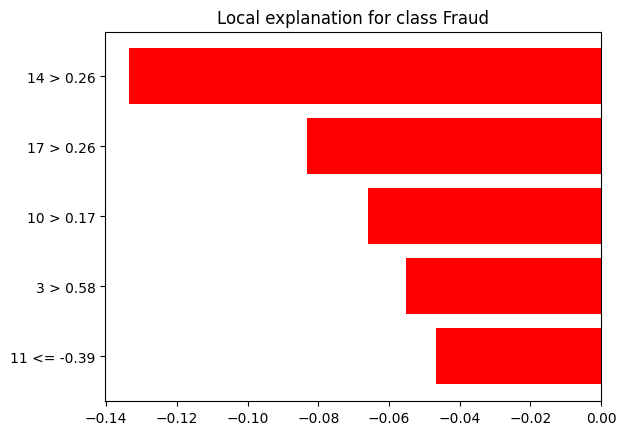

2025-07-20 16:31:18,393 - INFO - LIME explanation generated successfully.


2025-07-20 16:31:18,393 - INFO - LIME explanation generated successfully.


In [21]:


model_path = 'models/randomforestfor_credit_card_data.pkl'  
model = load_model(model_path) 
lime_explainability(model, X_train, X_test)


2025-07-20 16:31:22,858 - ERROR - Error in plotting global feature importance: 'numpy.ndarray' object has no attribute 'columns'


2025-07-20 16:31:22,858 - ERROR - Error in plotting global feature importance: 'numpy.ndarray' object has no attribute 'columns'
Error in plotting global feature importance: 'numpy.ndarray' object has no attribute 'columns'


2025-07-20 16:31:29,909 - ERROR - Error in generating PDP and ICE plots: 'numpy.ndarray' object has no attribute 'columns'


2025-07-20 16:31:29,909 - ERROR - Error in generating PDP and ICE plots: 'numpy.ndarray' object has no attribute 'columns'
Error in generating PDP and ICE plots: 'numpy.ndarray' object has no attribute 'columns'


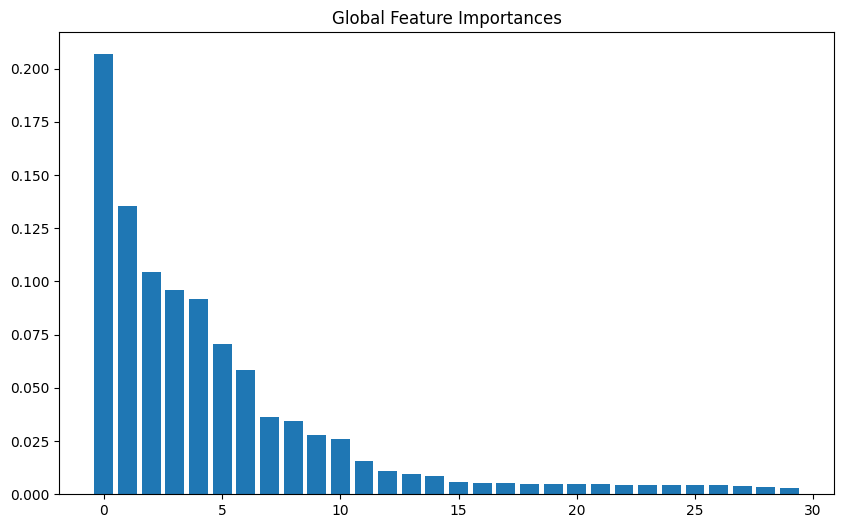

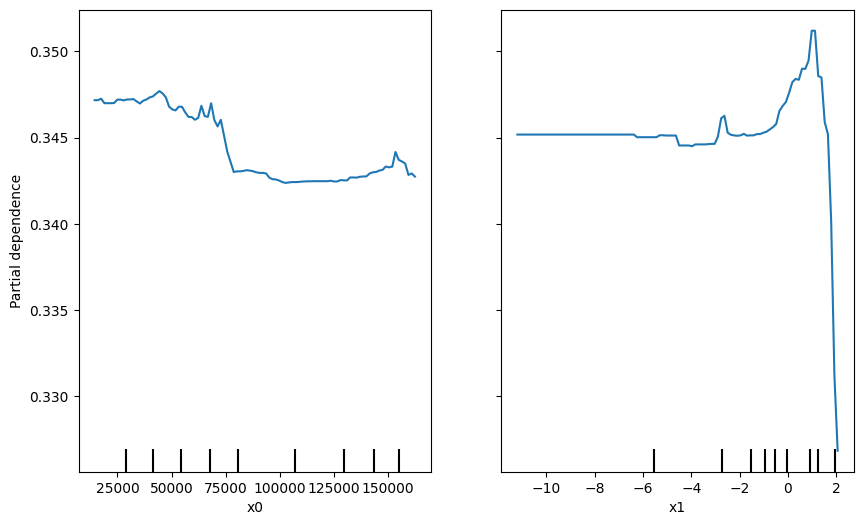

In [22]:
global_feature_importance(model, X_train)  # Plot global feature importance
pdp_ice_plots(model, X_train, [0, 1])  # Plot PDP and ICE for specified features

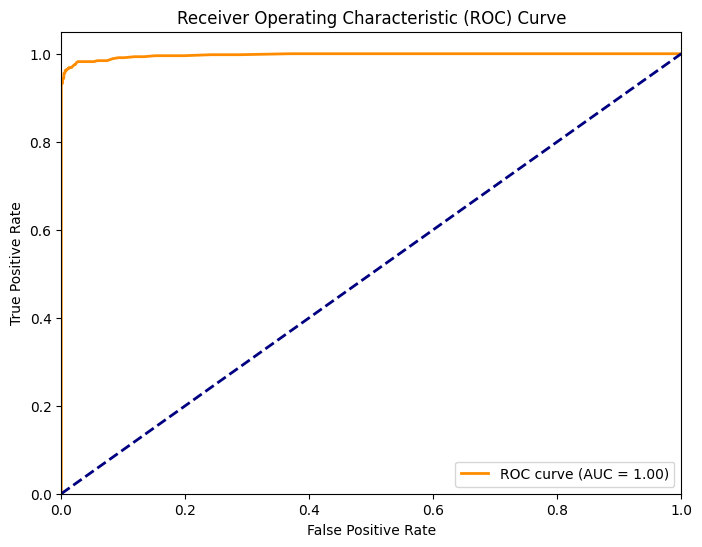

2025-02-11 13:39:47,180 - INFO - ROC Curve plotted successfully with AUC = 1.00.


2025-02-11 13:39:47,180 - INFO - ROC Curve plotted successfully with AUC = 1.00.


In [ ]:
plot_roc_auc(model, X_test, y_test)

In [23]:
fraud_df = fraud_df.sample(frac=1, random_state=42).reset_index(drop=True)
fraud_df = fraud_df.drop(columns=['Unnamed: 0', 'signup_time', 'purchase_time', 'device_id', 'ip_address'])
bool_cols = fraud_df.select_dtypes(include=['bool']).columns
fraud_df[bool_cols] = fraud_df[bool_cols].astype(int)

In [24]:
# Split data into features (X) and target (y)
X_u_o = fraud_df.drop(columns=['class'])
y_u_o = fraud_df['class']

# Split the original data into training and test sets
X_train, X_test, y_train, y_test = split_data(X_u_o, y_u_o, test_size=0.2, random_state=42)

# Convert Date-Time Column to Numerical Features if necessary





# Convert the training and test sets to 'float64' data type
X_train = X_train.astype('float64')
X_test = X_test.astype('float64')

2025-07-20 16:31:42,264 - INFO - Splitting data into train and test sets


2025-07-20 16:31:42,264 - INFO - Splitting data into train and test sets


In [25]:
# Define the resampling strategies
over = SMOTE(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.2)

# Split data into features (X) and target (y)
# Split data into features (X) and target (y)
X_u_o = fraud_df.drop(columns=['class'])
y_u_o = fraud_df['class']

# Apply under-sampling first
X_under, y_under = under.fit_resample(X_u_o, y_u_o)

# Apply over-sampling on the under-sampled data
X_resampled, y_resampled = over.fit_resample(X_under, y_under)

# Now you can use the resampled data for further processing
print(Counter(y_resampled))

Counter({0: 70755, 1: 35377})


In [27]:
# Set the path to your saved model (replace with the actual path)

model_path_fraud = 'models/random_forest_model_fraud.pkl'  
model_fraud = load_model(model_path_fraud) 



2025-07-20 16:31:56,318 - INFO - Model loaded successfully from models/random_forest_model_fraud.pkl


2025-07-20 16:31:56,318 - INFO - Model loaded successfully from models/random_forest_model_fraud.pkl


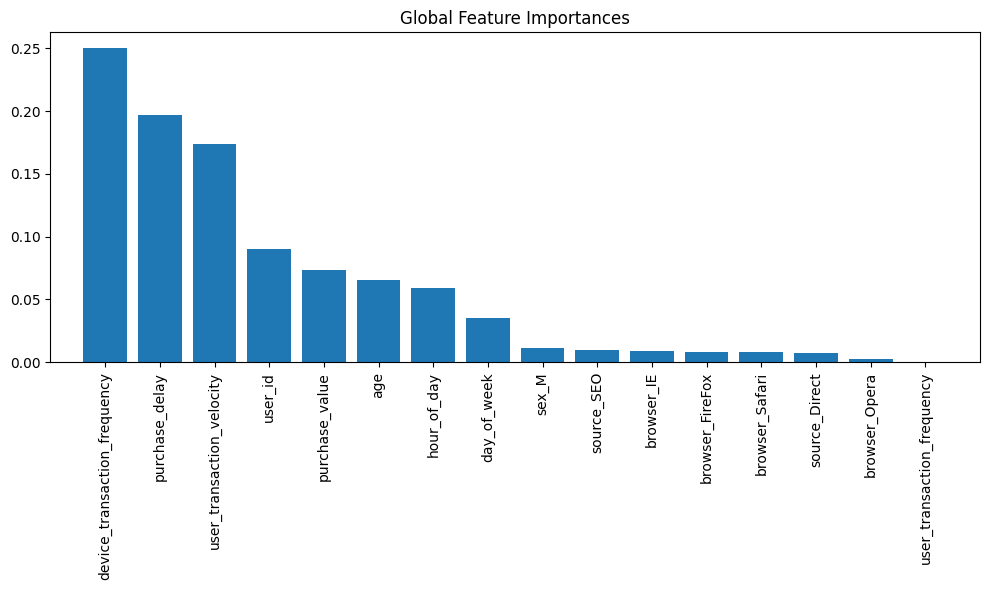

2025-07-20 16:31:59,164 - INFO - Global feature importance plotted successfully.


2025-07-20 16:31:59,164 - INFO - Global feature importance plotted successfully.


2025-07-20 16:37:47,572 - ERROR - Error in generating PDP and ICE plots: The ax was already used in another plot function, please set ax=display.axes_ instead


2025-07-20 16:37:47,572 - ERROR - Error in generating PDP and ICE plots: The ax was already used in another plot function, please set ax=display.axes_ instead
Error in generating PDP and ICE plots: The ax was already used in another plot function, please set ax=display.axes_ instead


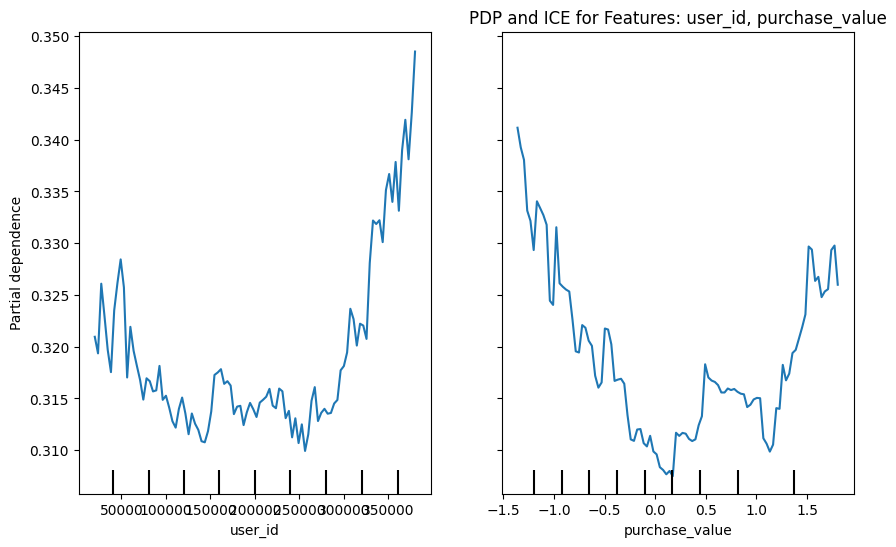

In [28]:
global_feature_importance(model_fraud, X_train)  # Plot global feature importance
pdp_ice_plots(model_fraud, X_train, [0, 1])  # Plot PDP and ICE for specified features

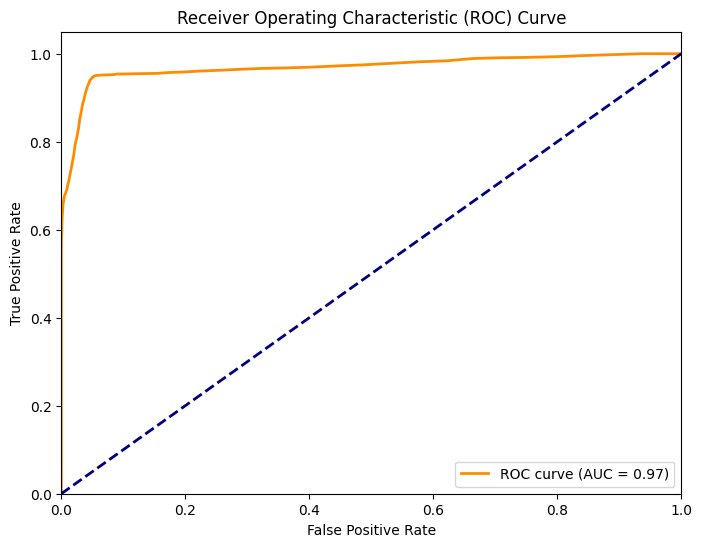

2025-07-20 16:37:48,423 - INFO - ROC Curve plotted successfully with AUC = 0.97.


2025-07-20 16:37:48,423 - INFO - ROC Curve plotted successfully with AUC = 0.97.


In [29]:
plot_roc_auc(model_fraud, X_test, y_test)